In [1]:
import warnings as _wrn
_wrn.filterwarnings('always')

In [2]:
import sys as _sys
import itertools as _itr

import numpy as _nmp
import numpy.random as _rnd
import matplotlib.pyplot as _plt
import pandas as _pnd

%load_ext autoreload
%autoreload 2
%matplotlib inline

_plt.style.use('ggplot')

In [3]:
import eQTLseq as _assoc

In [5]:
GENO = _nmp.loadtxt('/Users/dimitris/WTCHG/Workstation/Data/1000g/VCF/YRI/012/YRI.clean.anno.common.TF.HIGH.012', dtype='int')
GENO = GENO[:, _nmp.sum(GENO, 0) > 0]     # remove mono-morphic variants 
COUNTS = _pnd.read_table('/Users/dimitris/WTCHG/Workstation/Data/1000g/counts/YRI.counts.clean.txt')

data = {
    'G': GENO,
    'Z': COUNTS.iloc[:, 2:].values
}

print(data['G'].shape)
print(data['Z'].shape)

(58, 13)
(12407, 58)


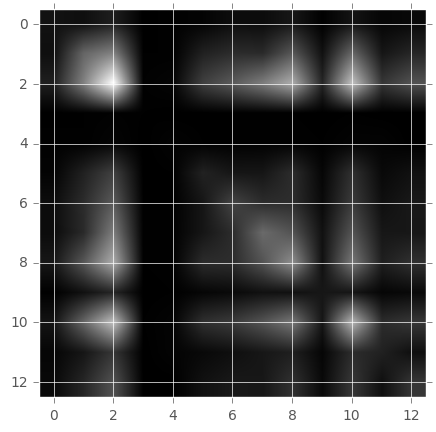

In [6]:
_plt.figure(figsize=(5,5));
_plt.imshow(data['G'].T.dot(data['G']), cmap=_plt.cm.Greys_r);

In [25]:
_rnd.seed(0)
Z = data['Z'] / _assoc.calculate_norm_factors(data['Z'])
# Z = _assoc.transform_data(Z, kind='log')
res = _assoc.run(Z, data['G'], n_iters = 1000, mdl='NBinomial', scale=True, n_threads=1)

Starting...
Iteration 1000 of 1000
Done!


array([[ 527,   12],
       [7110,    2]])

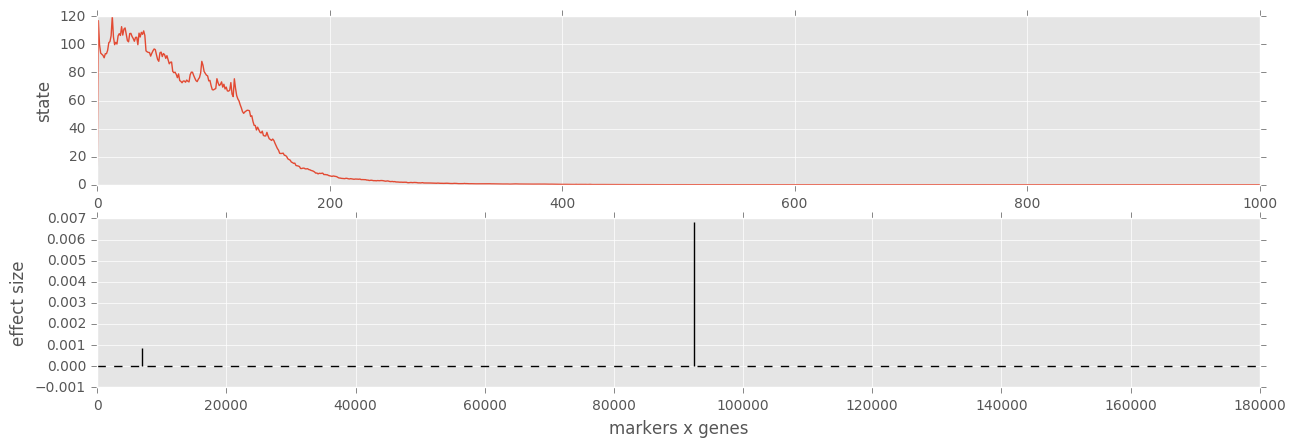

In [26]:
_plt.figure(figsize = (15,10));
_plt.subplot(4,1,1); _plt.plot(res['state']); _plt.xlabel('iteration'); _plt.ylabel('state')
_plt.subplot(4,1,2); _plt.vlines(range(res['beta'].size), 0, res['beta'].ravel()); _plt.xlabel('markers x genes'); _plt.ylabel('effect size')
_plt.axhline(linestyle='--', color='k');
_nmp.transpose((_nmp.abs(res['beta']) > 1e-6).nonzero())

In [18]:
(res['beta'] > 1e-6).sum()

0

In [20]:
_nmp.finfo('float').eps

2.2204460492503131e-16